# **Atmosphere Sanity Check**

## *Setup*


### Imports

Need to import wrf-python, cartopy, and netcdf in order to properly plot pressure, winds.

In [1]:
import wrf
from netCDF4 import Dataset #type: ignore
import numpy as np
import cartopy.crs as crs
import matplotlib.pyplot as plt
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cfeature
from matplotlib.cm import get_cmap

### Options & Basic Read In

Set the date, domain, plot type, and chem type. Adds basic variable read in. **NB:** Chem type is not ready to go yet beyond no chemistry (met option) 

In [2]:
year = 2023
month = 7
day = 21
hour = 18
domain = 2
plt_type = 'sfc'
chem_type = 'met'

wrffile = Dataset(f'2023/wrfout/wrfout_d{domain:02}_{year}-{month:02}-{day:02}_{hour:02}:00:00')

z = wrf.getvar(wrffile, 'z', units='m')
p = wrf.getvar(wrffile, 'pressure')


### Specific Read In

This cell reads in the proper variables for the plot specified in the setup above. **NB:** chem_type is still not supported (9/14/2024)

In [3]:
if chem_type != 'met':
    #! not ready yet... xghg = wrf.
    raise NotImplementedError('Chem not implemented yet. Please reconfigure.') #TODO Come back to this.
elif plt_type == 'sfc':
    t2 = wrf.getvar(wrffile, 'T2') - 273.15 # K -> deg C
    u_level, v_level = wrf.getvar(wrffile, 'uvmet10', units='kt')
    z_level = wrf.getvar(wrffile,'slp') #! Sea Level Pressure (slp) is added to z_level instead of height (z) for consistency in the plotting below.
    z_level= wrf.smooth2d(z_level, 3, cenweight=4)
else:
    ua = wrf.getvar(wrffile, 'ua', units='kt')
    va = wrf.getvar(wrffile, 'va', units='kt')
    u_level = wrf.interplevel(ua, p, 850. if plt_type == '850 hPa' else 500.)
    v_level = wrf.interplevel(va, p, 850. if plt_type == '850 hPa' else 500.)
    z_level = wrf.interplevel(z, p, 850. if plt_type == '850 hPa' else 500.) / 10. #m --> dam
lats, lons = wrf.latlon_coords(z)
cart_proj = wrf.get_cartopy(z)

## *Plotting*

### Main Analysis Plot

This cell plots the analysis that is set up above. 

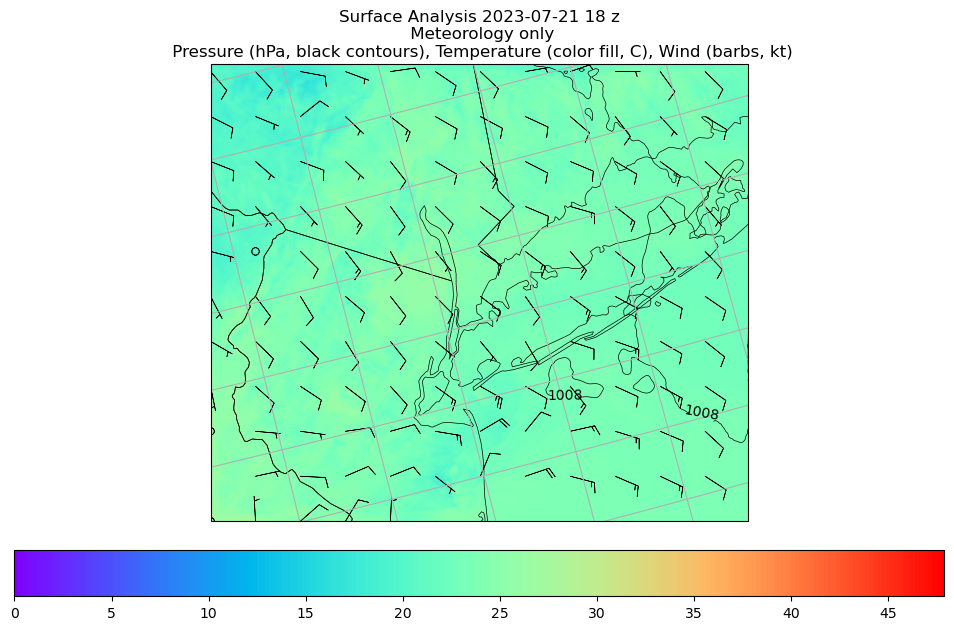

In [9]:
golden = (1. + np.sqrt(5.))/2.
figsize = (12., 12./golden)
fig, ax = plt.subplots(1,1, subplot_kw={'projection': cart_proj},figsize=figsize)

#states = NaturalEarthFeature(category='cultural',scale='50m',facecolor='none',name='admin_1_states_provinces')
#lakes = NaturalEarthFeature(category='physical', scale='50m', facecolor='none', name='lakes')
states = cfeature.STATES
ax.add_feature(states, linewidth=0.5, edgecolor='black')
#ax.coastlines('50m', linewidth=0.5)

if chem_type != 'met':
    pass #TODO: come back to this
else:
    if plt_type == 'sfc':
        t_levels = np.arange(0., 48., 0.1)
        t_contours = ax.contourf(wrf.to_np(lons), wrf.to_np(lats), wrf.to_np(t2), levels=t_levels, cmap=plt.get_cmap('rainbow'), transform=crs.PlateCarree())
        cbar_levels = np.arange(0., 48., 5)
        plt.colorbar(t_contours, ax=ax, orientation='horizontal', pad=0.05, ticks=cbar_levels)
        ax.barbs(wrf.to_np(lons[::25, ::25]), wrf.to_np(lats[::25, ::25]), wrf.to_np(u_level[::25, ::25]), wrf.to_np(v_level[::25, ::25]), lw = 0.5, length=6, transform=crs.PlateCarree())

    levels = np.arange(1004., 1028., 4.)
    contours = ax.contour(wrf.to_np(lons), wrf.to_np(lats), wrf.to_np(z_level), levels= levels, linewidths= 0.5, colors='black', transform=crs.PlateCarree())
    ax.clabel(contours, inline=True, fontsize=10.)

ax.set_xlim(wrf.cartopy_xlim(z_level))
ax.set_ylim(wrf.cartopy_ylim(z_level))

ax.gridlines()
if chem_type != 'met':
    pass #TODO: come back to this
else:
    plt.title(f'{"Surface" if plt_type=="sfc" else plt_type} Analysis {year}-{month:02}-{day:02} {hour:02} z\n Meteorology only\n Pressure (hPa, black contours), Temperature (color fill, C), Wind (barbs, kt)')
    plt.savefig(f'{plt_type}-d{domain:02}-{year}-{month:02}-{day:02}_{hour:02}z.png')
plt.show()
plt.close()

In [1]:
from wrf import omp_get_num_procs, omp_set_num_threads, omp_get_max_threads

In [2]:
print(omp_get_num_procs())

48


In [3]:
print(omp_get_max_threads())

1


In [4]:
omp_set_num_threads(30)

print(omp_get_max_threads())

30


In [5]:
from wrf import omp_enabled

print(omp_enabled())

True
